# Unraveling Personalities: A Data-Driven Exploration Using 16PF Questionnaire Responses

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pylab import cm

# Cleaning of the datasets and exploratory analysis

In this project I will use two datasets.

## First dataset

The first contains the 162 statements to which each participant had to assign a score from 1 to 5. If they strongly agree with the statement they have to answer 5, if they strongly disagree, 1. This first dataset also contains the defining codes for the names of countries.

In [2]:
cb = pd.read_csv('D:/My files/IP Paris/Courses - First Year/Python for Data Science/Project_personality/16PF/codebook.csv', sep = ";")
print(cb.shape)
cb.sample(10)

(421, 3)


,Field,Format,Description
355,NaN,NaN,"QA ""Qatar"""
31,C9,INTEGER,"""I feel desperate"""
259,NaN,NaN,"GT ""Guatemala"""
25,C3,INTEGER,"""I readily overcome setbacks"""
181,NaN,NaN,"AW ""Aruba"""
233,NaN,NaN,"EH ""Western Sahara"""
373,NaN,NaN,"SN ""Senegal"""
203,NaN,NaN,"BY ""Belarus"""
163,NaN,NaN,NaN
144,O2,INTEGER,"""I get chores done right away"""


Since we only need the questions let's start by dropping everything else

In [3]:
# drop all the rows that have index > 162
cb.drop(cb.index[162:], inplace=True)

In [4]:
print(cb.shape)
cb.sample(10)

(162, 3)


,Field,Format,Description
84,I2,INTEGER,"""I suspect hidden motives in others"""
98,J6,INTEGER,"""I take deviant positions"""
15,B6,INTEGER,"""I counter others' arguments"""
121,L9,INTEGER,"""I am not easily bothered by things"""
159,P7,INTEGER,"""I judge people by their appearance"""
52,E10,INTEGER,"""I dislike loud music"""
90,I8,INTEGER,"""I trust others"""
136,N4,INTEGER,"""I seek quiet"""
77,H5,INTEGER,"""I cry during movies"""
23,C1,INTEGER,"""I seldom feel blue"""


## Second dataset
The second dataset contains the answers of almost 50,000 participants to the 162 statements and some additional information, such as age, gender and country.

In [5]:
df = pd.read_csv('D:/My files/IP Paris/Courses - First Year/Python for Data Science/Project_personality/16PF/data.csv', sep='	')
print(df.shape)
df.head()

(49159, 169)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P7,P8,P9,P10,age,gender,accuracy,country,source,elapsed
0,1,4,2,3,3,2,3,4,4,3,...,1,2,5,2,17,1,92,US,6,914
1,4,3,4,3,4,4,4,4,2,2,...,3,2,2,2,37,1,100,US,1,891
2,3,4,4,4,4,4,4,3,2,2,...,2,3,3,3,31,1,80,US,6,903
3,4,5,4,4,4,3,3,2,2,2,...,2,3,4,4,32,1,93,US,1,806
4,4,0,4,4,4,3,5,1,2,4,...,4,2,3,2,46,2,87,NZ,1,1826


This dataset comes from an online questionnaire, this means that every person that decided to answer the questionnaire was free to answer as they liked. After a thorough analysis I noticed that many people did not answer the survey seriously, by answering randomly or by inserting inaccurate information. For this reason it is particularly important to clean well the dataset, trying to identify the people that answered the questionnaire seriously.
For the same reason I will conduct the exploratory analysis while cleaning the dataset; understanding the dataset is the only way to find the people that answered untruthfully.

Let's check if there are duplicates in the rows and empty values and let's drop them

In [6]:
print(f"There are {df.duplicated().sum()} duplicated rows in the dataset")
print(f"There are {df.isnull().sum().sum()} empty values in the dataset")

df.dropna(inplace=True)

There are 0 duplicated rows in the dataset
There are 17 empty values in the dataset


## Accuracy

At the end of the questionnaire each person had to grade with a number from 1 to 100 the precision of their answers. Let's start by removing the participants who said that were not precise in their responses

In [7]:
num_rows = df[df['accuracy'] > 100].shape[0]
print("The number of rows with accuracy > 100 is:", num_rows)

num_rows2 = df[df['accuracy'] < 80].shape[0]
print("The number of rows with accuracy < 80  is:", num_rows2)


# let's delete the rows with accuracy > 100 and accuracy < 80
df.drop(df[df['accuracy'] > 100].index, inplace=True)
df.drop(df[df['accuracy'] < 80].index, inplace=True)

The number of rows with accuracy > 100 is: 23
The number of rows with accuracy < 80  is: 5958


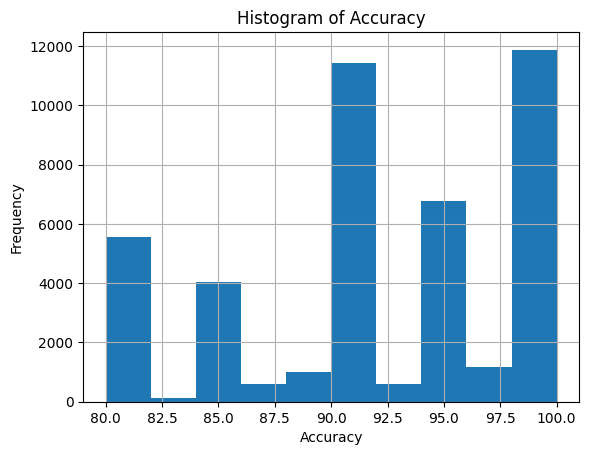

In [8]:
df["accuracy"].hist()
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Histogram of Accuracy')
plt.show()

The column _source_ and _accuracy_ are not relevant for our study as the first one describes how the participants found the questionnaire and the second one how confident they where of their answers

In [9]:
df.drop(['source', 'accuracy'], axis = 1, inplace=True)

In the dataset there are some rows containing all the same value. Let's remove them

In [10]:
for answer in range(6):
    num_rows_with_zeros = (df.iloc[:, :163] == answer).all(axis=1).sum()
    print(f"The number of rows with only {answer} in the first 163 columns is: {num_rows_with_zeros}")
    df = df[~(df.iloc[:, :163] == answer).all(axis=1)]

The number of rows with only 0 in the first 163 columns is: 100


The number of rows with only 1 in the first 163 columns is: 23
The number of rows with only 2 in the first 163 columns is: 2
The number of rows with only 3 in the first 163 columns is: 22
The number of rows with only 4 in the first 163 columns is: 6
The number of rows with only 5 in the first 163 columns is: 26


Many rows contain a lot of zeros. The value zero as an answer means that the answer of the participant was not correctly saved. \
If in a row there are many zeros let's completely erase the row, otherwise let's change the value 0 with the value of the average answer for that specific question.

The number of rows with at least one 0 in the first 163 columns is: 11773


The number of zeros in the first 163 columns is: 51285
The number of rows with at least 20 zeros in the first 163 columns is: 307


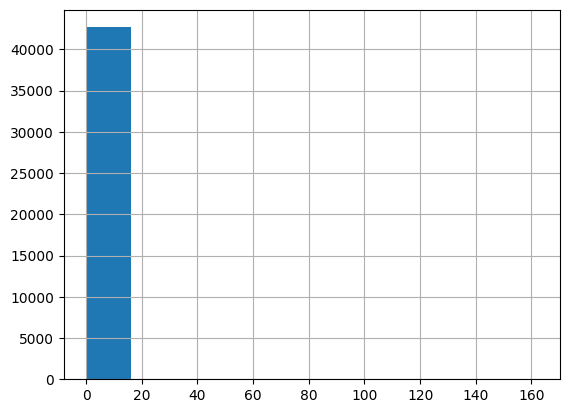

In [11]:
num_rows_with_zeros = (df.iloc[:, :163] == 0).any(axis=1).sum()
print(f"The number of rows with at least one 0 in the first 163 columns is: {num_rows_with_zeros}")
num_zeros = (df.iloc[:, :163] == 0).sum().sum()
print(f"The number of zeros in the first 163 columns is: {num_zeros}")

num_zeros_per_row = (df.iloc[:, :163] == 0).sum(axis=1)

num_zeros_per_row.hist()

num_rows_with_at_least_20_zeros = (num_zeros_per_row >= 20).sum()
print(f"The number of rows with at least 20 zeros in the first 163 columns is: {num_rows_with_at_least_20_zeros}")
df = df[~(num_zeros_per_row >= 5)]


df = df.replace(0, np.nan)
df.iloc[:, :163] = df.iloc[:, :163].fillna(df.iloc[:, :163].mean())

Some people answered the same number for many consecutive questions.
Let's first study the distribution of the number of consecutive values by plotting their histogram and then remove the "unusual data", _i.e._ the participants that answer the same value for _too many_ times consecutively

In [12]:
consecutive_counts = []

for row in df.iterrows():
    consecutive_count = [0] * 5
    max_consecutive_count = [0] * 5
    for value in row[1]:
        for i in range(1, 6):
            if value == i:
                consecutive_count[i-1] += 1
                max_consecutive_count[i-1] = max(max_consecutive_count[i-1], consecutive_count[i-1])
            else:
                consecutive_count[i-1] = 0
    consecutive_counts.append(max_consecutive_count)

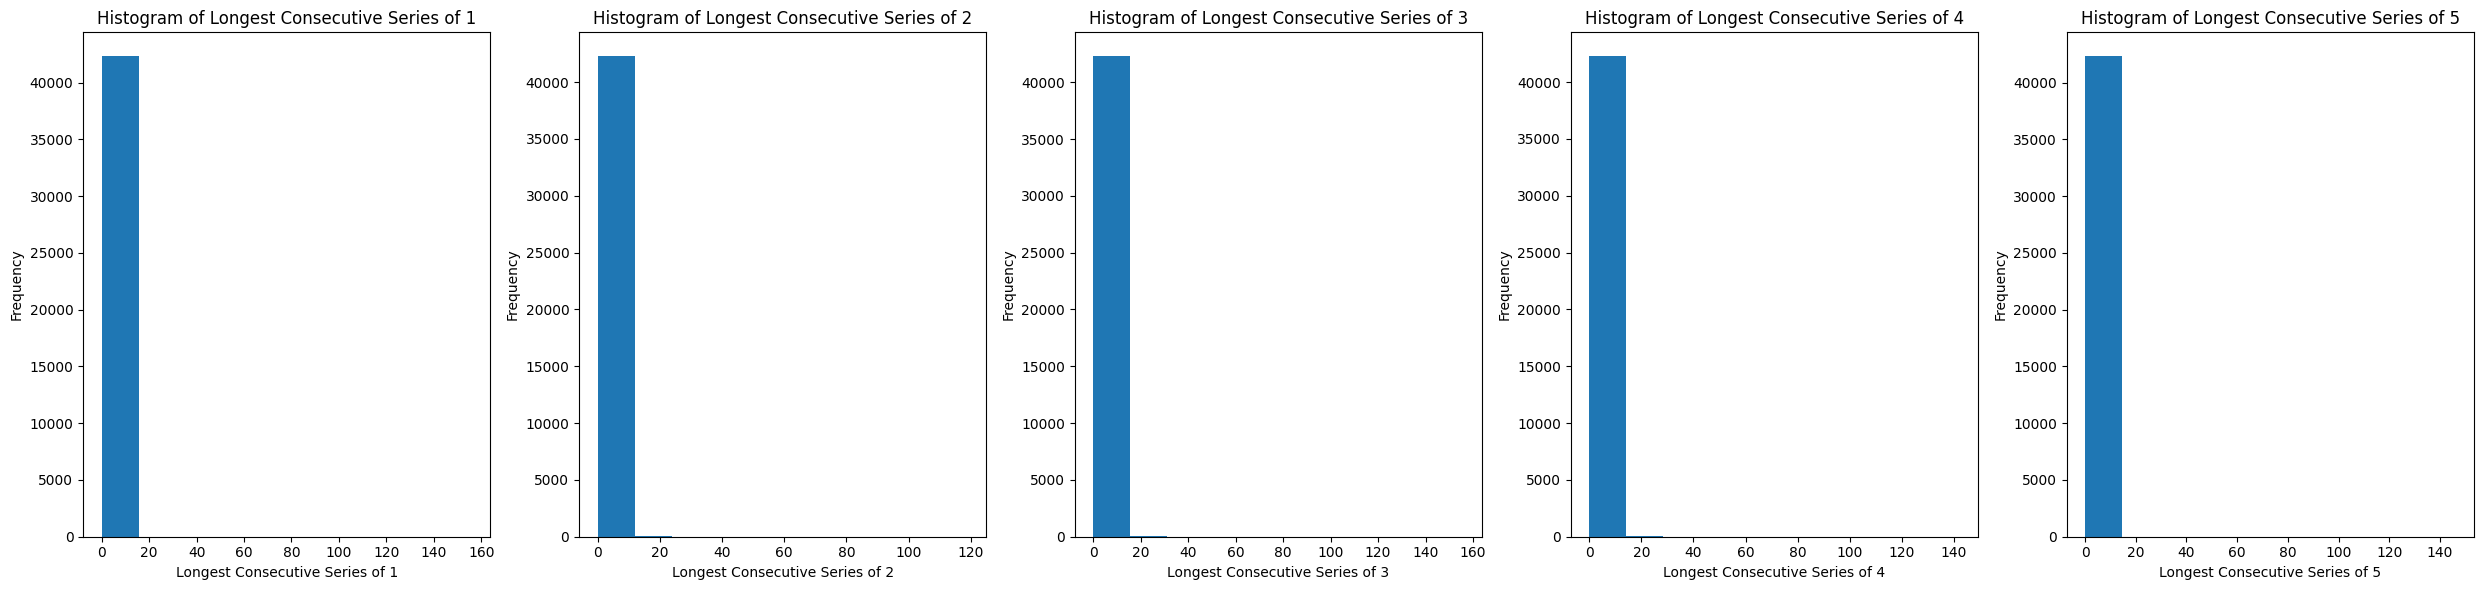

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(25, 6))

for i in range(5):
    axes[i].hist([counts[i] for counts in consecutive_counts])
    axes[i].set_xlabel(f'Longest Consecutive Series of {i+1}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of Longest Consecutive Series of {i+1}')

plt.tight_layout()
plt.show()

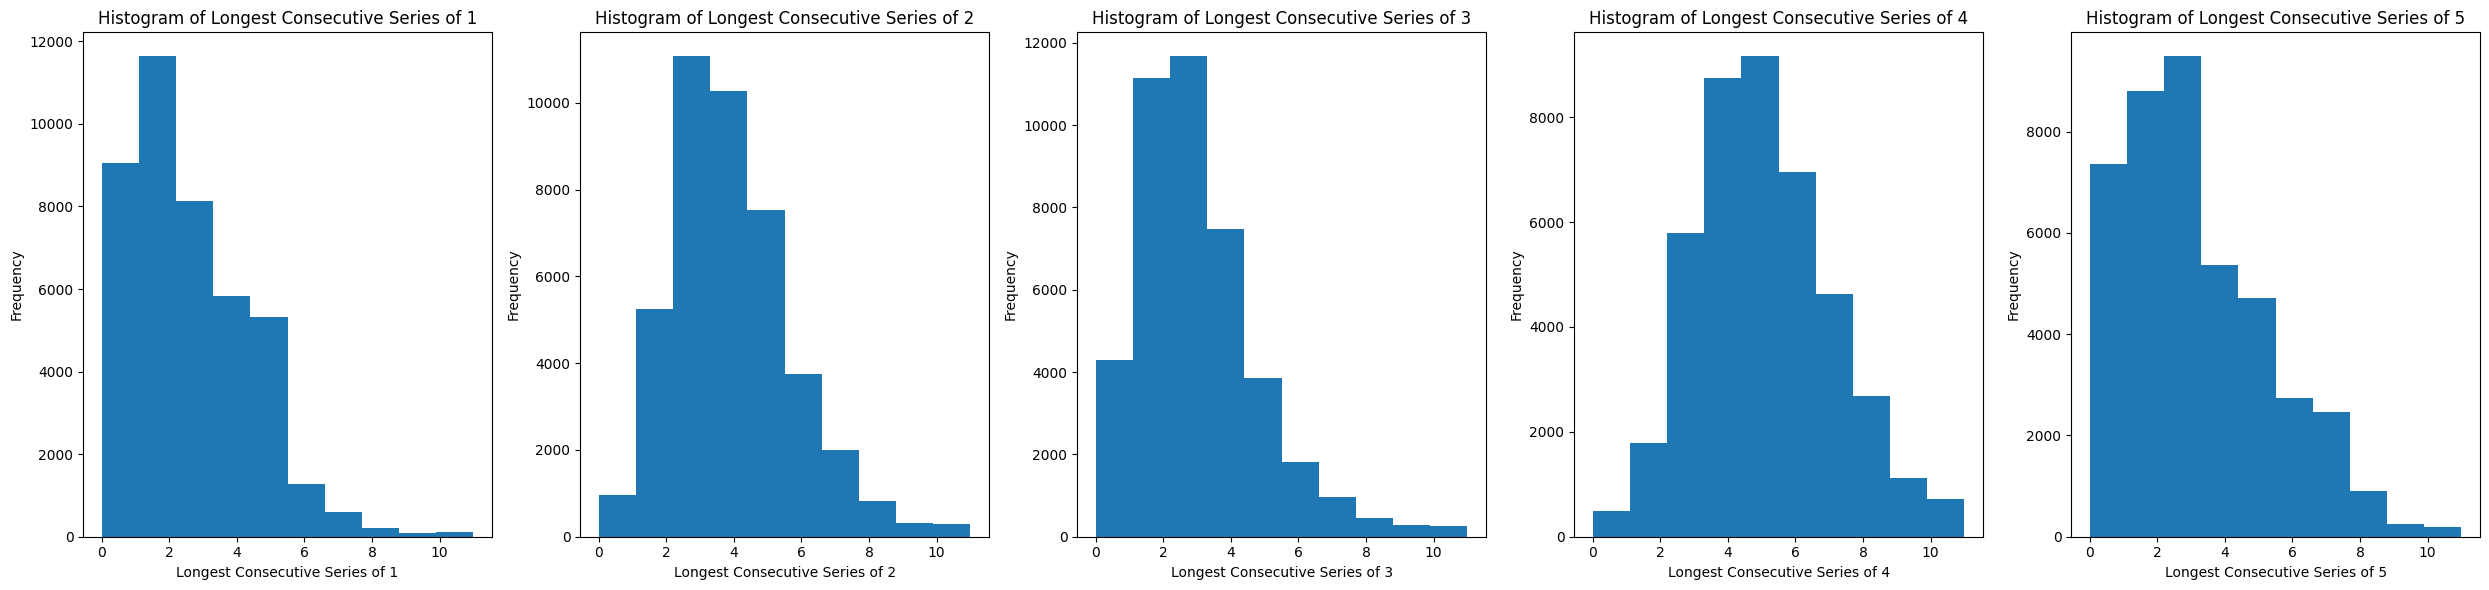

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(25, 6))

for i in range(5):
    axes[i].hist([counts[i] for counts in consecutive_counts if counts[i] < 12])
    axes[i].set_xlabel(f'Longest Consecutive Series of {i+1}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of Longest Consecutive Series of {i+1}')

plt.tight_layout()
plt.show()

Looking at the distribution it seems like we can remove all the rows where the number of consecutive values is larger than 12

In [15]:
df = df[~(np.array(consecutive_counts[:len(df)]) > 12).any(axis=1)]

Finally let's remove all the rows that only contain 2 values

In [16]:
num_rows = ((df.iloc[:, :163] == 2) | (df.iloc[:, :163] == 4)).all(axis=1).sum()
print("The number of rows where only the values 2 or 4 appear in the first 163 columns is:", num_rows)
for i in range(1, 6):
    for j in range(i+1, 6):
        num_rows = ((df.iloc[:, :163] == i) | (df.iloc[:, :163] == j)).all(axis=1).sum()
        print(f"The number of rows where only the values {i} or {j} appear in the first 163 columns is:", num_rows)
        df = df[~((df.iloc[:, :163] == i) | (df.iloc[:, :163] == j)).all(axis=1)]

The number of rows where only the values 2 or 4 appear in the first 163 columns is: 20
The number of rows where only the values 1 or 2 appear in the first 163 columns is: 1
The number of rows where only the values 1 or 3 appear in the first 163 columns is: 0
The number of rows where only the values 1 or 4 appear in the first 163 columns is: 0
The number of rows where only the values 1 or 5 appear in the first 163 columns is: 43
The number of rows where only the values 2 or 3 appear in the first 163 columns is: 0
The number of rows where only the values 2 or 4 appear in the first 163 columns is: 20
The number of rows where only the values 2 or 5 appear in the first 163 columns is: 0
The number of rows where only the values 3 or 4 appear in the first 163 columns is: 1
The number of rows where only the values 3 or 5 appear in the first 163 columns is: 0
The number of rows where only the values 4 or 5 appear in the first 163 columns is: 2


## Age

In [17]:
print(df[["age", "gender", "country"]].nunique())
df["gender"].info()

age        127
gender       3
country    153
dtype: int64
<class 'pandas.core.series.Series'>
Index: 41951 entries, 0 to 49158
Series name: gender
Non-Null Count  Dtype  
--------------  -----  
41747 non-null  float64
dtypes: float64(1)
memory usage: 655.5 KB


While plotting some histograms I noticed that some age values were too high, the oldest person alive is 114 so let's remove all the participants with a age too high

In [18]:
print("The number of rows with age > 90 is:", df['age'][df['age'] > 90].count())
df = df.drop(df[df['age'] > 90].index)

The number of rows with age > 90 is: 58


<Axes: >

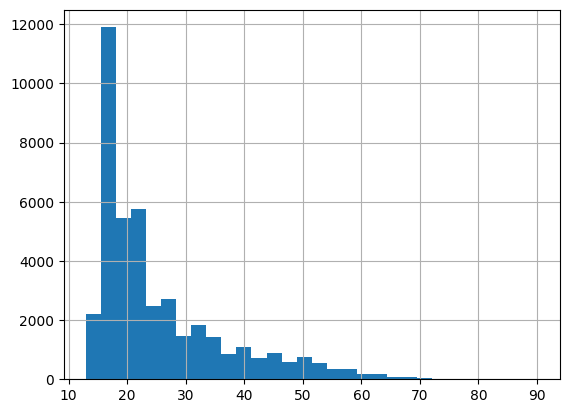

In [19]:
df['age'].hist(bins=30)

## Country

<Axes: xlabel='country'>

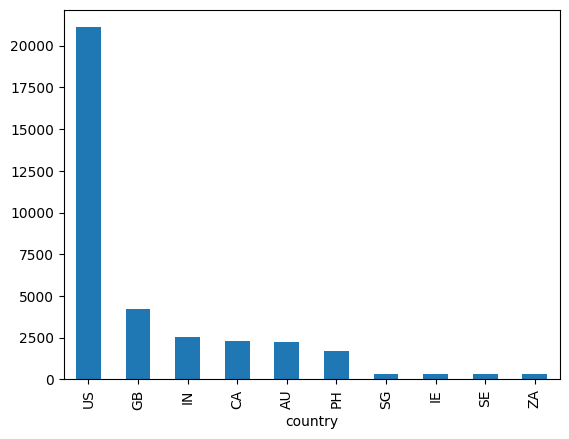

In [20]:
df['country'].value_counts().head(10).plot(kind='bar')

## Gender
The participants of gender 0 are the ones where the gender was not saved, we can remove them since they are very little

In [21]:
print(df['gender'].value_counts())

df = df.drop(df[df['gender'] == 0].index)

gender
2.0    25125
1.0    16359
3.0      206
Name: count, dtype: int64


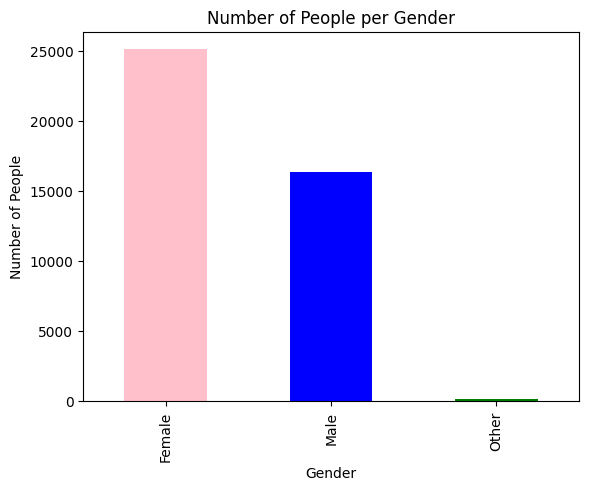

In [22]:
df['gender'].value_counts().plot(kind='bar', color=['pink', 'blue', 'green'])
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.title('Number of People per Gender')
plt.xticks(range(df['gender'].nunique()), ['Female', 'Male', 'Other'])
plt.show()


## Time spent to complete the questionnaire in seconds

776 people spend more than 2 hours doing the questionnaire, we can remove them

In [23]:
df = df.drop(df[df['elapsed'] > 7200].index)
df = df.drop(df[df['elapsed'] < 200].index)

We can also study the distribution of the answers for specific questions

In [24]:
# Function that allows us to get the statement in the codebook from the index of the question
def get_question(n):
    return cb.iloc[n]['Description']

print(get_question(69))
print(cb.loc[cb['Field'] == "A5"])

"I often feel uncomfortable around others" 
  Field   Format           Description
4    A5  INTEGER  "I cheer people up" 


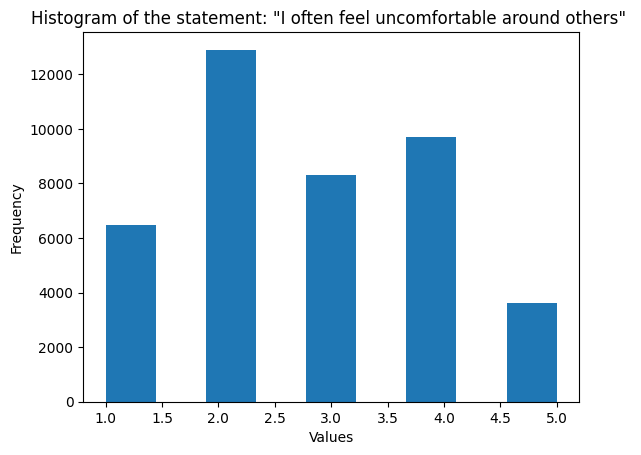

In [25]:
column_number = 69

plt.hist(df.iloc[:, column_number], bins=5*2-1)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of the statement: {get_question(column_number)}')
plt.show()

# PCA

Answering 160 questions can be challenging, let's see if we can reduce the number of questions to create a smaller questionnaire that is still effective. \
PCA will also be very useful to plot some results after utilizing some clustering methods

In [26]:
df_PCA = df.drop(['country', 'age', 'gender', 'elapsed'], axis = 1)

Let's implement PCA and apply it on our data set.

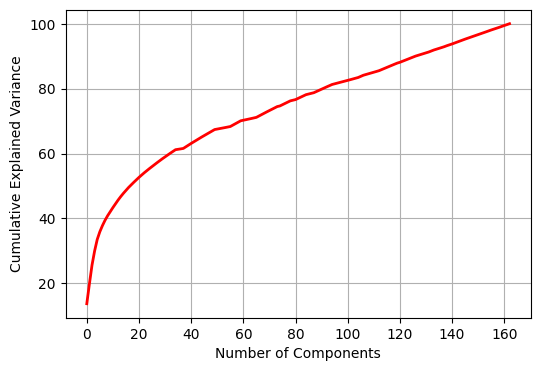

In [27]:
def pca(X, k):
    # Standardize the data
    X_std = (X - np.mean(X, axis=0))

    # Compute the covariance matrix
    cov_matrix = np.cov(X_std.T)

    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))]
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)

    # Select the top k eigenvectors
    projection_matrix = np.array([pair[1] for pair in eigen_pairs[:k]]).T

    # Project the data onto the new feature space
    transformed_data = np.dot(X_std, projection_matrix)

    # Calculate the percentage of variance explained by each component
    variance_explained = []
    for i in range(len(eigenvalues)):
        variance_explained.append((eigenvalues[i] / sum(eigenvalues)) * 100)

    # Plot the cumulative variance explained by all the components
    cumulative_variance_explained = np.cumsum(variance_explained)

    plt.figure(1, figsize=(6, 4))

    plt.clf()
    plt.plot(cumulative_variance_explained, linewidth=2, color = 'red')
    plt.axis('tight')
    plt.grid()
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

    return transformed_data, eigen_pairs, cumulative_variance_explained, projection_matrix

X = df_PCA.to_numpy()
transformed_data, eigen_pairs, cumulative_variance_explained, projection_matrix = pca(X, k=20)

After studying the graph of the cumulative explained variance and looking at the most important questions that contribute to each principal component, I decided to keep the first 7 pc for my analysis.

In [28]:
# Function that shows us the top m statements that explain the principal component number n
def explain_column(n, m = 3):
    top_indices = np.argsort(abs(eigen_pairs[n][1]))[::-1][:m]
    for i in range(len(top_indices)):
        print(top_indices[i], get_question(top_indices[i]))
    
k = 7
for i in range(k):
    print("Principal Component", i+1)
    explain_column(i)
    print()

print("The cumulative variance explained by the first 7 components is:", round(cumulative_variance_explained[k-1], 2))

Principal Component 1
68 "I find it difficult to approach others" 
66 "I make friends easily" 
69 "I often feel uncomfortable around others" 

Principal Component 2
48 "I act wild and crazy" 
28 "I have frequent mood swings" 
46 "I enjoy being part of a loud crowd" 

Principal Component 3
56 "I respect authority" 
18 "I consider myself an average person" 
59 "I break rules" 

Principal Component 4
75 "I read a lot" 
73 "I like to read" 
80 "I do not like poetry" 

Principal Component 5
149 "I am not bothered by disorder" 
148 "I am not bothered by messy people" 
150 "I leave a mess in my room" 

Principal Component 6
55 "I believe in one true religion" 
103 "I reveal little about myself" 
107 "I keep my thoughts to myself" 

Principal Component 7
109 "I am open about my feelings" 
108 "I am open about myself to others" 
111 "I show my feelings" 

The cumulative variance explained by the first 7 components is: 37.79


In the questionnaire the statements are grouped in groups of approximately 10. For this reason the questions that compose the first pc all come from the same group. It is also interesting to notice that statements coming from groups are still grouped in a way that makes sense

In [29]:
# Let's print the main question per principal component
print(f"{k} most important statements:")
for i in range(k):
    explain_column(i, 1)

7 most important statements:
68 "I find it difficult to approach others" 
48 "I act wild and crazy" 
56 "I respect authority" 
75 "I read a lot" 
149 "I am not bothered by disorder" 
55 "I believe in one true religion" 
109 "I am open about my feelings" 


Let's now try to cluster the participants into different groups, each representing a personality type. I'm will use 2 techniques, K-Means and GMM.

# K-Means Clustering

After defining the function and doing some testing I decided to take K = 5

In [30]:
def kmeans(X, k, max_iters=300):
    # Initialize centroids randomly
    centroids = X[np.random.choice(range(X.shape[0]), size=k, replace=False)]

    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1)
        labels = np.argmin(distances, axis=-1)

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids, rtol=1e-05):
            break

        centroids = new_centroids

    print(f"I did {_} iterations")

    return labels, centroids


X = df_PCA.to_numpy()
c = 5

labels1, centroids1 = kmeans(X, c)

df['labels'] = labels1

# print("Labels1:", labels1)
# print("Centroids:", centroids1)


I did 89 iterations


Let's plot the distribution of the labels and the graph on the 2 main principal components of the clustered dataframe

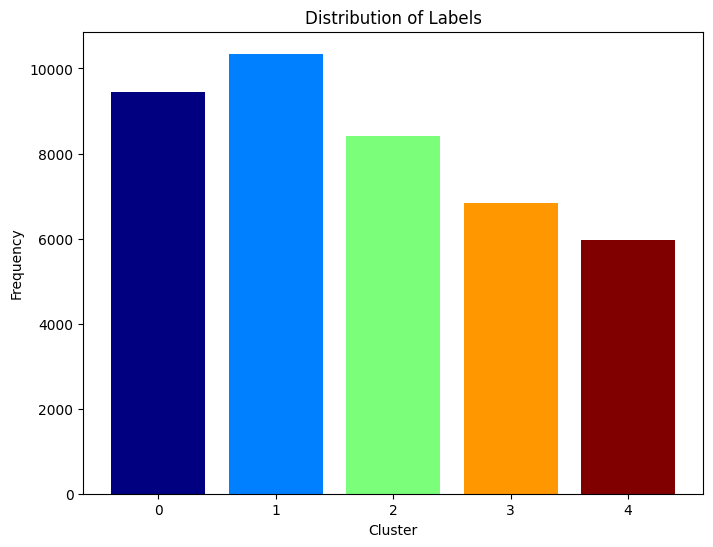

In [31]:
colors = ['#000080', '#0080ff', '#7bff7b', '#ff9700', '#800000']  # Let's specify the colors for each cluster

plt.figure(figsize=(8, 6))
for i in range(len(colors)):
    plt.bar(i, labels1[labels1 == i].size, color=colors[i])

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()

C:\Users\lucab\AppData\Local\Temp\ipykernel_16668\1418441287.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', c)


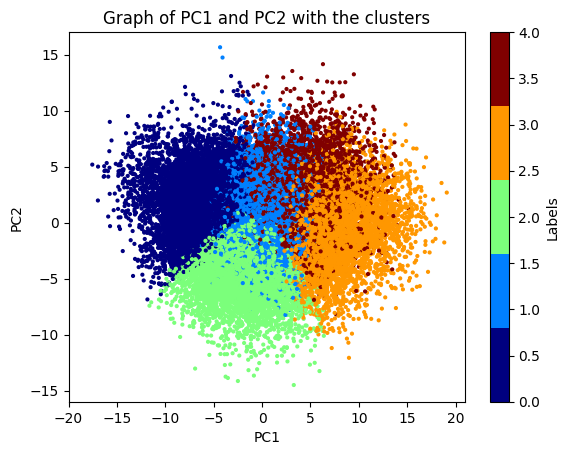

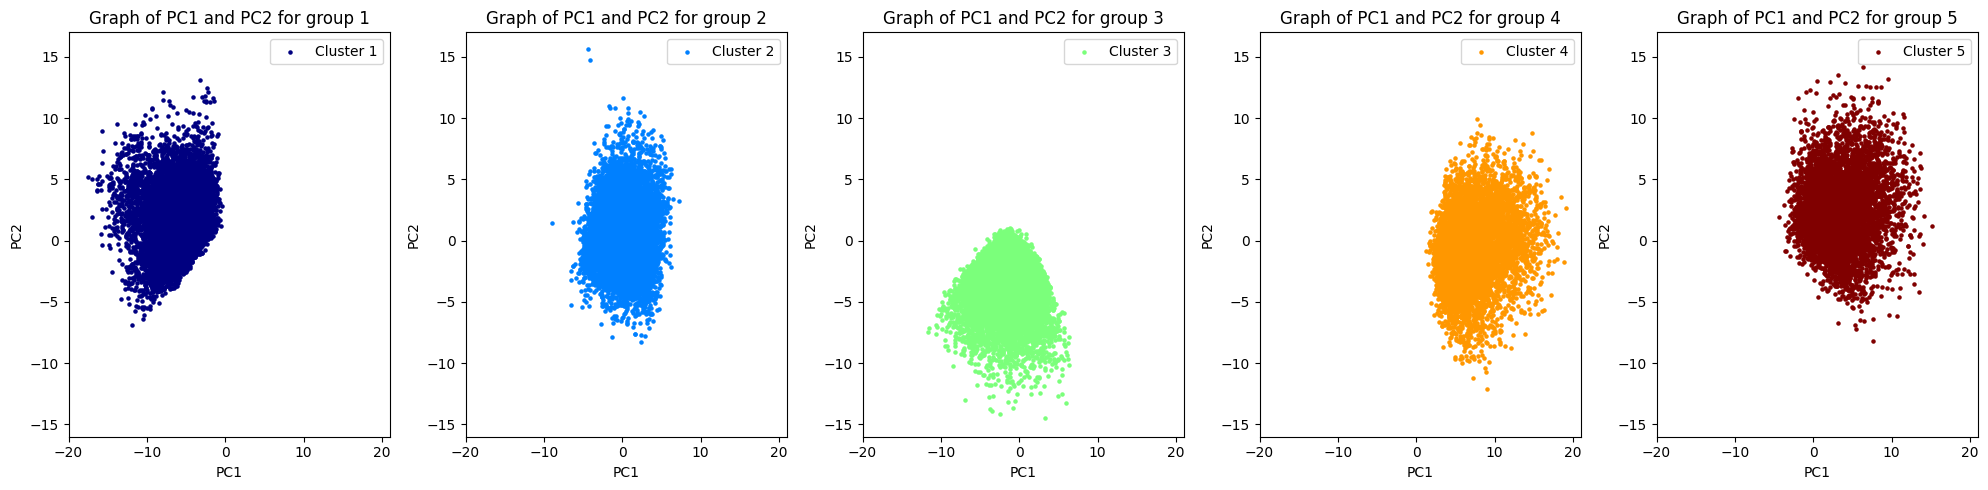

In [32]:
pc1_values = transformed_data[:, 0]
pc2_values = transformed_data[:, 1]

cmap = cm.get_cmap('jet', c)

plt.scatter(pc1_values, pc2_values, c=labels1, cmap=cmap, s = 4)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Graph of PC1 and PC2 with the clusters')
plt.colorbar(label='Labels')
plt.xlim(-20, 21)  # Set x-axis limits
plt.ylim(-16, 17)  # Set y-axis limits
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(c):
    axes[i].scatter(pc1_values[labels1 == i], pc2_values[labels1 == i], color=colors[i], s=5, label=f'Cluster {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    axes[i].set_title(f'Graph of PC1 and PC2 for group {i+1}')
    axes[i].legend()
    axes[i].set_xlim(-20, 21)  # Set x-axis limits
    axes[i].set_ylim(-16, 17)

plt.tight_layout()
plt.show()

# GMM

Instead of using K-Means we could also opt for a probabilistic approach. This approach can be justified because personality traits often follow a normal distribution, meaning that if we consider a trait such as "Extrovertness" we can say that most of the population will score average in this trait and few people will be very high or very low in this trait, in a symmetric way.

In [33]:
class GaussianMixtureModelLuca:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize the parameters
        self.means = np.random.randn(self.n_components, n_features)
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.ones(self.n_components) / self.n_components

        # Iterate until convergence or maximum number of iterations
        print("Starting iterations...")
        for _ in range(self.max_iter):
            # Expectation step
            responsibilities = self._expectation(X)

            # Maximization step
            self._maximization(X, responsibilities)

            # Calculate the log-likelihood
            log_likelihood = self._log_likelihood(X)
            print(f"Iteration: {_ + 1}/{self.max_iter} done")
            # Check for convergence
            # if len(log_likelihood) >= 2 and np.abs(log_likelihood[-1] - log_likelihood[-2]) < self.tol:
            # print(np.abs(log_likelihood[-1] - log_likelihood[-2]))
                # break


    def _expectation(self, X):
        n_samples, _ = X.shape

        # Calculate the responsibilities
        responsibilities = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self._multivariate_normal(X, self.means[k], self.covariances[k])

        # Check for zero responsibilities and assign a small value instead
        responsibilities[responsibilities == 0] = 1e-10

        # Normalize the responsibilities
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

        return responsibilities

    def _maximization(self, X, responsibilities):
        n_samples, n_features = X.shape

        # Update the means, covariances, and weights
        for k in range(self.n_components):
            Nk = np.sum(responsibilities[:, k])

            # Update the means
            self.means[k] = np.sum(responsibilities[:, k].reshape(-1, 1) * X, axis=0) / Nk

            # Update the covariances
            diff = X - self.means[k]
            self.covariances[k] = np.dot((responsibilities[:, k].reshape(-1, 1) * diff).T, diff) / Nk

            # Update the weights
            self.weights[k] = Nk / n_samples

    def _multivariate_normal(self, X, mean, covariance):
        n_features = X.shape[1]
        det = np.linalg.det(covariance)
        inv = np.linalg.inv(covariance)
        norm = 1 / np.sqrt((2 * np.pi) ** n_features * det)
        exponent = -0.5 * np.sum(np.dot(X - mean, inv) * (X - mean), axis=1)

        return norm * np.exp(exponent)

    def _log_likelihood(self, X):
        log_likelihood = np.log(np.sum(self._expectation(X), axis=1))
        return log_likelihood


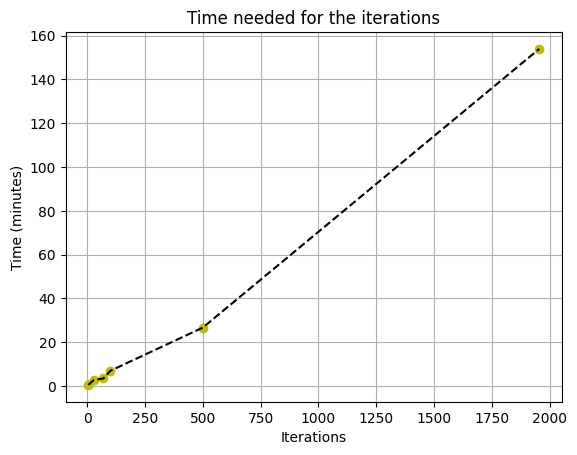

In [34]:
iterazioni = [5,10, 30, 70, 100, 500, 1955]
tempo_interazioni = [29, 59, 168, 206, 415, 1599, 9235]

# divide the tempo itezazioni by 60
tempo_interazioni = [tempo_interazioni[i] / 60 for i in range(len(tempo_interazioni))]
plt.plot(iterazioni, tempo_interazioni, "yo", iterazioni, tempo_interazioni, "--k")

# call the x axis "Iterations" and the y axis "Time (hours)
plt.xlabel('Iterations')
plt.ylabel('Time (minutes)')
plt.title('Time needed for the iterations')
plt.grid()
plt.show()

In [35]:
gmmL = GaussianMixtureModelLuca(n_components=5, max_iter=50)

# Fit the model to the data
gmmL.fit(X)

# Get the responsibilities for each sample
responsibilities = gmmL._expectation(X)

Starting iterations...
Iteration: 1/50 done
Iteration: 2/50 done
Iteration: 3/50 done
Iteration: 4/50 done
Iteration: 5/50 done
Iteration: 6/50 done
Iteration: 7/50 done
Iteration: 8/50 done
Iteration: 9/50 done
Iteration: 10/50 done
Iteration: 11/50 done
Iteration: 12/50 done
Iteration: 13/50 done
Iteration: 14/50 done
Iteration: 15/50 done
Iteration: 16/50 done
Iteration: 17/50 done
Iteration: 18/50 done
Iteration: 19/50 done
Iteration: 20/50 done
Iteration: 21/50 done
Iteration: 22/50 done
Iteration: 23/50 done
Iteration: 24/50 done
Iteration: 25/50 done
Iteration: 26/50 done
Iteration: 27/50 done
Iteration: 28/50 done
Iteration: 29/50 done
Iteration: 30/50 done
Iteration: 31/50 done
Iteration: 32/50 done
Iteration: 33/50 done
Iteration: 34/50 done
Iteration: 35/50 done
Iteration: 36/50 done
Iteration: 37/50 done
Iteration: 38/50 done
Iteration: 39/50 done
Iteration: 40/50 done
Iteration: 41/50 done
Iteration: 42/50 done
Iteration: 43/50 done
Iteration: 44/50 done
Iteration: 45/50 d

Let's plot the distribution of the labels and the graph of the participants divided into groups with respect to pc1 and pc2

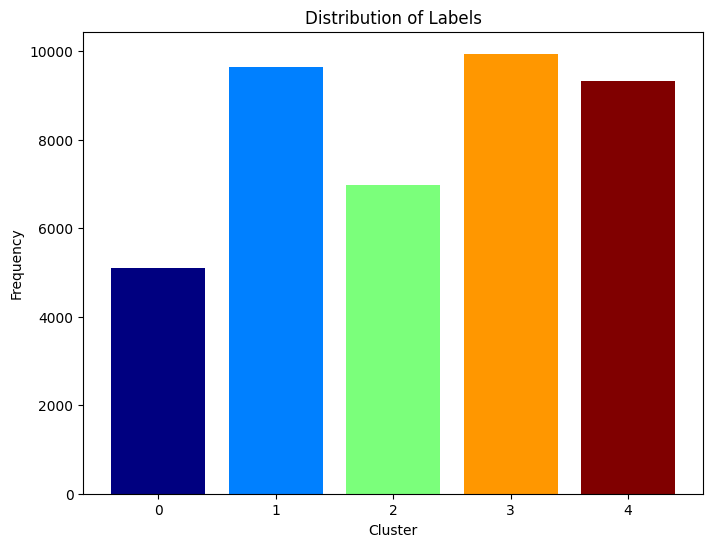

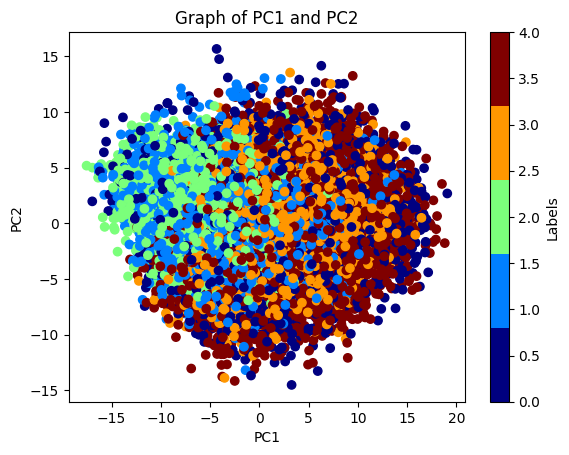

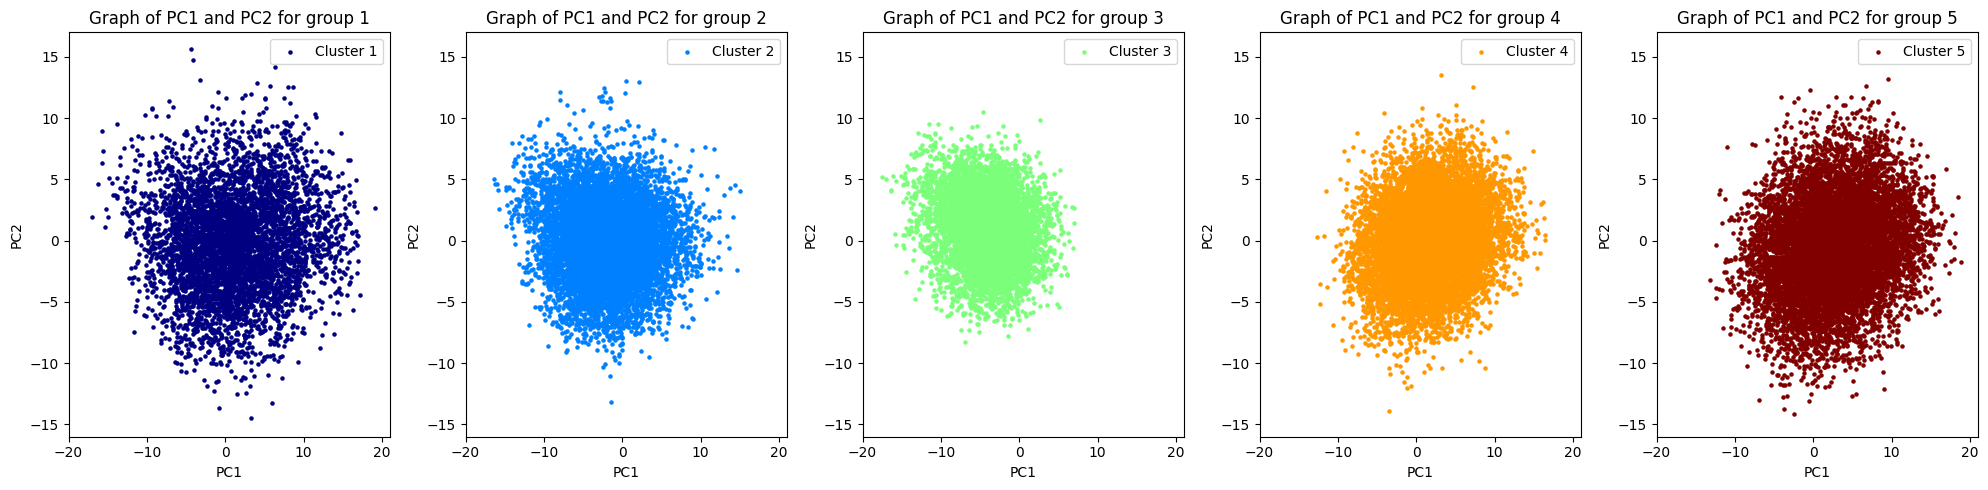

In [36]:
labels2 = np.argmax(responsibilities, axis=1)

plt.figure(figsize=(8, 6))
for i in range(len(colors)):
    plt.bar(i, labels2[labels2 == i].size, color=colors[i])

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()


plt.scatter(pc1_values, pc2_values, c=labels2, cmap=cmap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Graph of PC1 and PC2')
plt.colorbar(label='Labels')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(c):
    axes[i].scatter(pc1_values[labels2 == i], pc2_values[labels2 == i], color=colors[i], s=5, label=f'Cluster {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    axes[i].set_title(f'Graph of PC1 and PC2 for group {i+1}')
    axes[i].legend()
    axes[i].set_xlim(-20, 21)  # Set x-axis limits
    axes[i].set_ylim(-16, 17)

plt.tight_layout()
plt.show()

We can notice that the division is much less noticeable when plotting the participants over the 2 main principal components. Furthermore the final aim of this research is to be able to divide the participants in different personality groups and be able to give a label to each groups such as "the group of the calm people" and so on. For this reason I decided to keep the results obtained from K-Means

# Personality classification

To be able to classify the personality of the different groups we can look at the centroid for each group and see how it would answer the questions that make up the 7 main pcs

In [37]:
# let's print the most important question for the first c components
for i in range(c):
    indexx = np.argsort(abs(eigen_pairs[i][1]))[::-1][0]
    print(indexx, get_question(indexx))
print()

num_ques = k
for cen in range(len(centroids1)):
    for ques in range(num_ques):
        indexx = np.argsort(abs(eigen_pairs[ques][1]))[::-1][0]
        print(f"Person {cen+1}  Q: {get_question(indexx)}, A: {round(centroids1[cen, indexx], 1)}")
    print()


68 "I find it difficult to approach others" 
48 "I act wild and crazy" 
56 "I respect authority" 
75 "I read a lot" 
149 "I am not bothered by disorder" 

Person 1  Q: "I find it difficult to approach others" , A: 1.9
Person 1  Q: "I act wild and crazy" , A: 2.6
Person 1  Q: "I respect authority" , A: 4.1
Person 1  Q: "I read a lot" , A: 3.7
Person 1  Q: "I am not bothered by disorder" , A: 2.8
Person 1  Q: "I believe in one true religion" , A: 2.7
Person 1  Q: "I am open about my feelings" , A: 3.7

Person 2  Q: "I find it difficult to approach others" , A: 3.0
Person 2  Q: "I act wild and crazy" , A: 2.7
Person 2  Q: "I respect authority" , A: 4.1
Person 2  Q: "I read a lot" , A: 3.0
Person 2  Q: "I am not bothered by disorder" , A: 2.7
Person 2  Q: "I believe in one true religion" , A: 3.2
Person 2  Q: "I am open about my feelings" , A: 3.1

Person 3  Q: "I find it difficult to approach others" , A: 2.3
Person 3  Q: "I act wild and crazy" , A: 3.7
Person 3  Q: "I respect authority" 

In [38]:
index_mod = [66, 48, 56, 75, 150, 55, 109]

for i in range(c):
    indexx = np.argsort(abs(eigen_pairs[i][1]))[::-1][0]
    print(index_mod[i], get_question(index_mod[i]))

print()


for cen in range(len(centroids1)):
    for ques in range(num_ques):
        print(f"Person {cen+1}  S: {get_question(index_mod[ques])}, A: {round(centroids1[cen, index_mod[ques]], 1)}")
    print()

66 "I make friends easily" 
48 "I act wild and crazy" 
56 "I respect authority" 
75 "I read a lot" 
150 "I leave a mess in my room" 

Person 1  S: "I make friends easily" , A: 4.1
Person 1  S: "I act wild and crazy" , A: 2.6
Person 1  S: "I respect authority" , A: 4.1
Person 1  S: "I read a lot" , A: 3.7
Person 1  S: "I leave a mess in my room" , A: 2.5
Person 1  S: "I believe in one true religion" , A: 2.7
Person 1  S: "I am open about my feelings" , A: 3.7

Person 2  S: "I make friends easily" , A: 3.4
Person 2  S: "I act wild and crazy" , A: 2.7
Person 2  S: "I respect authority" , A: 4.1
Person 2  S: "I read a lot" , A: 3.0
Person 2  S: "I leave a mess in my room" , A: 3.0
Person 2  S: "I believe in one true religion" , A: 3.2
Person 2  S: "I am open about my feelings" , A: 3.1

Person 3  S: "I make friends easily" , A: 4.0
Person 3  S: "I act wild and crazy" , A: 3.7
Person 3  S: "I respect authority" , A: 3.3
Person 3  S: "I read a lot" , A: 3.6
Person 3  S: "I leave a mess in my

To better understand the answers of the centroids we can plot some graphs. I first plotted some scatter plots to see at a glance how every couple of statements is graded

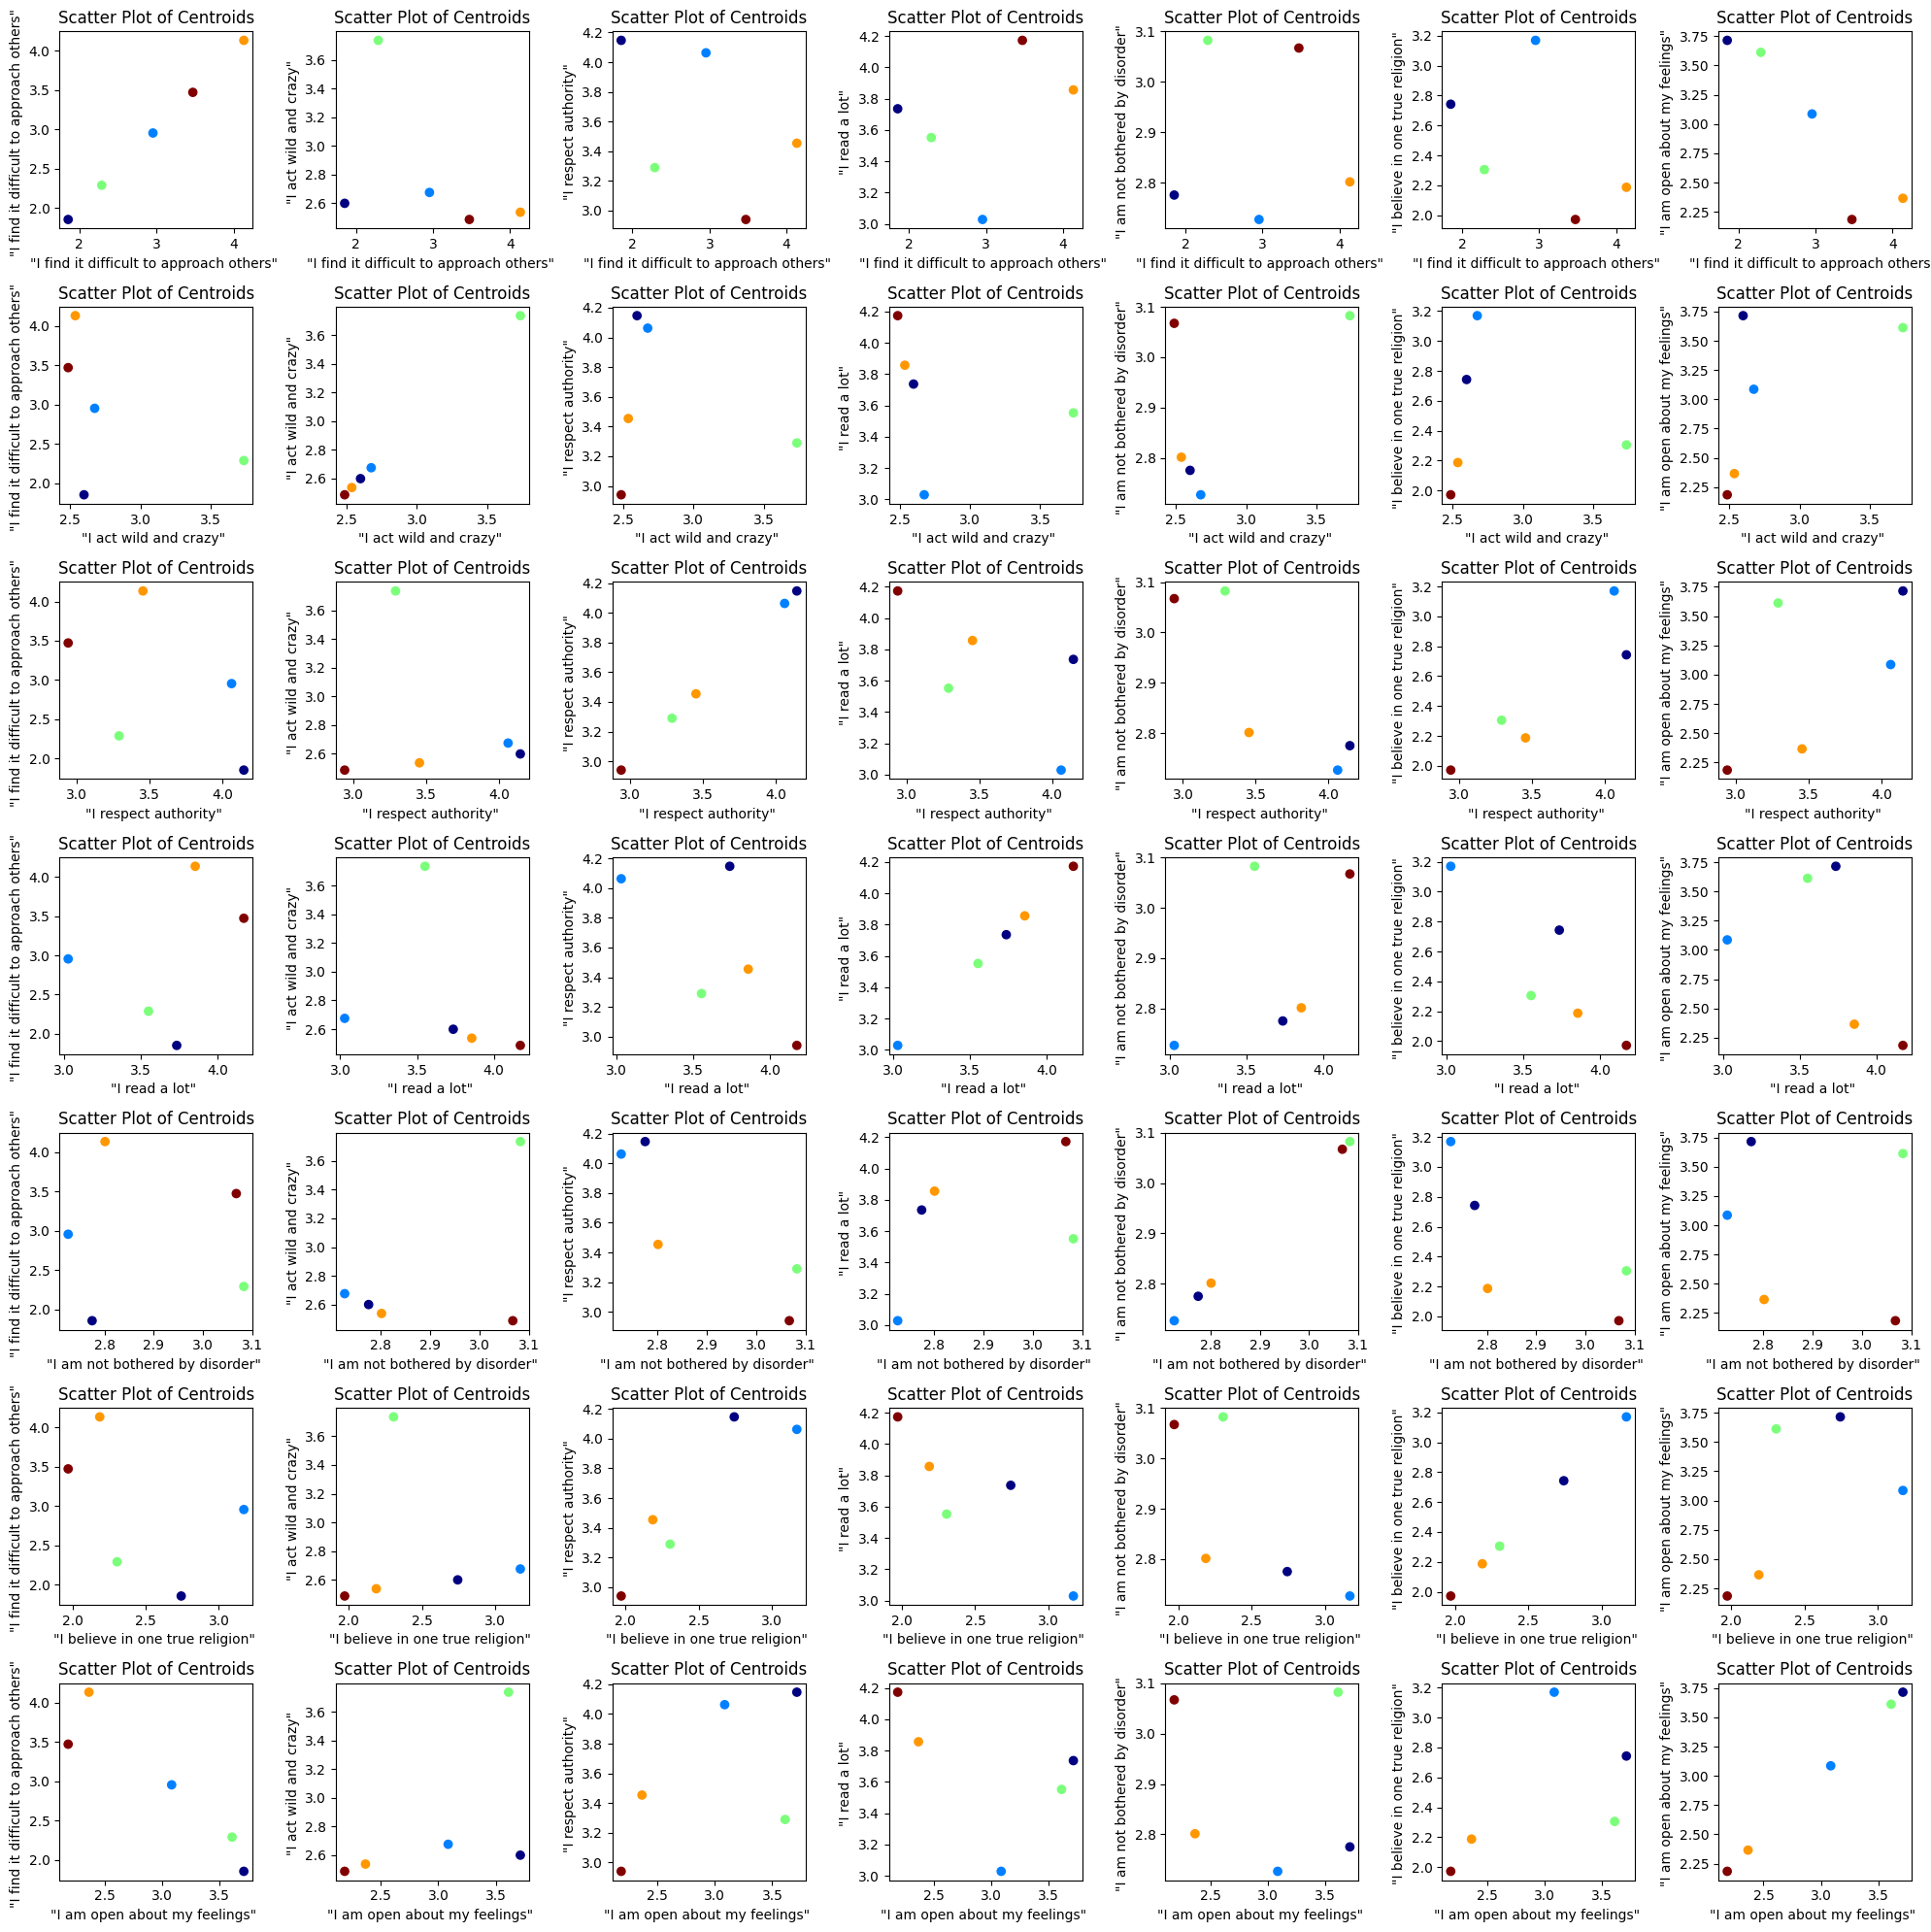

Centroid 0. Q: "I find it difficult to approach others" , A: 1.8535719412287375
Centroid 0. Q: "I act wild and crazy" , A: 2.599225516584926
Centroid 0. Q: "I respect authority" , A: 4.146737878546675
Centroid 0. Q: "I read a lot" , A: 3.735961883303669
Centroid 0. Q: "I am not bothered by disorder" , A: 2.7751691873733453
Centroid 0. Q: "I believe in one true religion" , A: 2.7426307433867665
Centroid 0. Q: "I am open about my feelings" , A: 3.7146079114394035

Centroid 1. Q: "I find it difficult to approach others" , A: 2.954354147813302
Centroid 1. Q: "I act wild and crazy" , A: 2.6750977300326815
Centroid 1. Q: "I respect authority" , A: 4.062743904766857
Centroid 1. Q: "I read a lot" , A: 3.028667663436451
Centroid 1. Q: "I am not bothered by disorder" , A: 2.726637617434682
Centroid 1. Q: "I believe in one true religion" , A: 3.1697855776330717
Centroid 1. Q: "I am open about my feelings" , A: 3.085856581719191

Centroid 2. Q: "I find it difficult to approach others" , A: 2.28936

In [39]:
fig, axes = plt.subplots(k, k, figsize=(20, 20))

for i in range(k):
    for j in range(k):
        #if i != j: # we can plot some graphs twice for simplicity
            index1 = np.argsort(abs(eigen_pairs[i][1]))[::-1][0]
            index2 = np.argsort(abs(eigen_pairs[j][1]))[::-1][0]
            ax = axes[i, j]
            ax.scatter(centroids1[:, index1], centroids1[:, index2], c=range(len(centroids1)), cmap=cmap)
            ax.set_xlabel(get_question(index1))
            ax.set_ylabel(get_question(index2))
            ax.set_title('Scatter Plot of Centroids')

plt.tight_layout()
plt.show()

for cen in range(len(centroids1)):
    for ques in range(num_ques):
        indexx = np.argsort(abs(eigen_pairs[ques][1]))[::-1][0]
        print(f"Centroid {cen}. Q: {get_question(indexx)}, A: {centroids1[cen, indexx]}")
    print()


I then plotted a radar graph to be able to directly compare all the answers of all the centroids at once

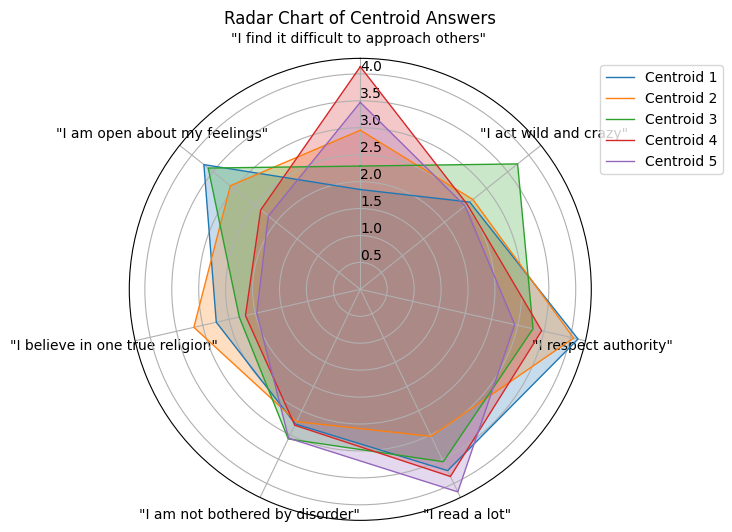

In [40]:
# Define the number of questions and centroids
num_questions = k
num_centroids = len(centroids1)

# Create a list of question labels
question_labels = [get_question(np.argsort(abs(eigen_pairs[i][1]))[::-1][0]) for i in range(num_questions)]

# Create a list of centroid labels
centroid_labels = [f"Centroid {i+1}" for i in range(num_centroids)]

# Create a list of values for each centroid
centroid_values = [[centroids1[cen, np.argsort(abs(eigen_pairs[ques][1]))[::-1][0]] for ques in range(num_questions)] for cen in range(num_centroids)]

# Calculate the angle for each question
angles = np.linspace(0, 2 * np.pi, num_questions, endpoint=False).tolist()
angles += angles[:1]

# Create the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

# Plot the values for each centroid
for i in range(num_centroids):
    values = centroid_values[i]
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=centroid_labels[i])
    ax.fill(angles, values, alpha=0.25)

# Set the labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(question_labels)
ax.set_title('Radar Chart of Centroid Answers')

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# Show the radar chart
plt.show()

Note: performing K-Means different times will return different results

After carefully analyzing we can come up with 5 possible groups.\
Centroid 1: The Disciplined Scholar\
Centroid 2: The Bookish Introvert\
Centroid 3: The Sociable Leader\
Centroid 4: The Creative Free Spirit\
Centroid 5: The Conscientious Traditionalist. 

We can also study how the different genders are distributed in the clusters

In [41]:
description = [
    "1: The Disciplined Scholar",
    "2: The Bookish Introvert",
    "3: The Sociable Leader",
    "4: The Creative Free Spirit",
    "5: The Conscientious Traditionalist"
]

description_gender = {1: "Male", 2: "Female", 3: "Other"}

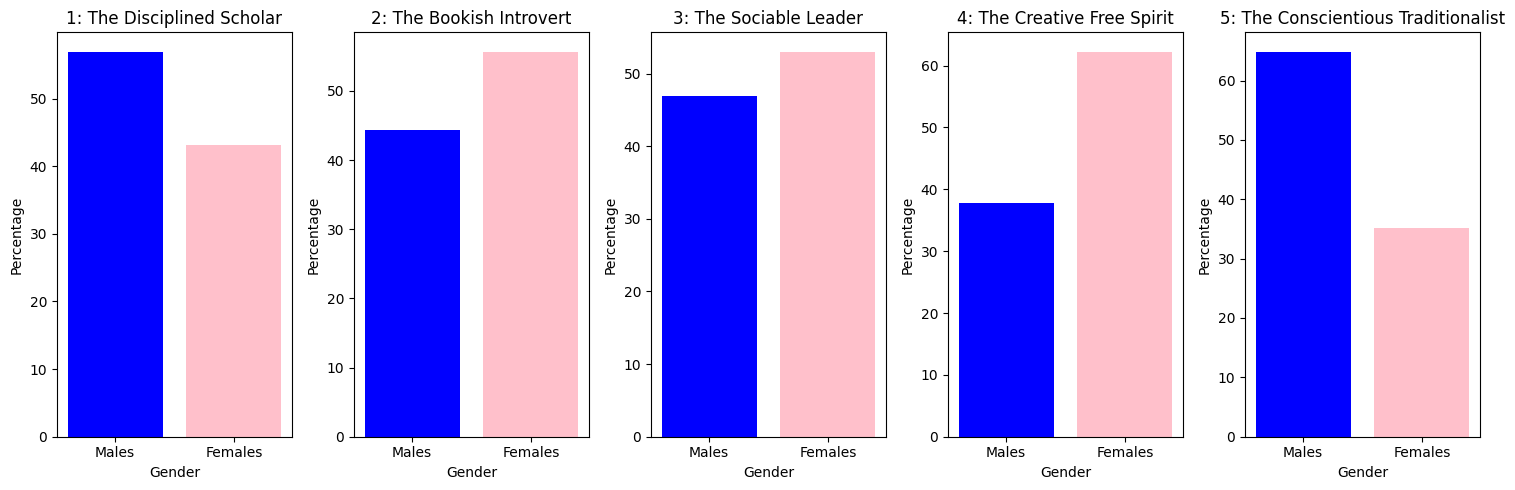

In [42]:
total_male_counts = np.sum(df['gender'] == 1)
total_female_counts = np.sum(df['gender'] == 2)
total_other_counts = np.sum(df['gender'] == 3)

female_to_male_ratio = total_female_counts / total_male_counts
female_to_other_ratio = total_female_counts / total_other_counts

# Create subplots for the histograms
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    # Count the number of males and females in each cluster
    male_counts = np.sum((df['gender'] == 1) & (df['labels'] == i)) * female_to_male_ratio
    female_counts = np.sum((df['gender'] == 2) & (df['labels'] == i))
    other_counts = np.sum((df['gender'] == 3) & (df['labels'] == i)) * female_to_other_ratio

    # Calculate the percentage of males and females in each cluster
    male_percentages = male_counts / (male_counts + female_counts) * 100
    female_percentages = female_counts / (male_counts + female_counts) * 100
    other_percentages = other_counts / (male_counts + female_counts + other_counts) * 100

    # Plot the histograms
    labels = ['Males', 'Females']
    percentages = [male_percentages, female_percentages]

    colori = ['blue', 'pink', 'purple']  # Specify the colors here

    # Plot the histogram in the corresponding subplot
    axes[i].bar(labels, percentages, color=colori)
    axes[i].set_xlabel('Gender')
    axes[i].set_ylabel('Percentage')
    axes[i].set_title(description[i])

plt.tight_layout()
plt.show()
    

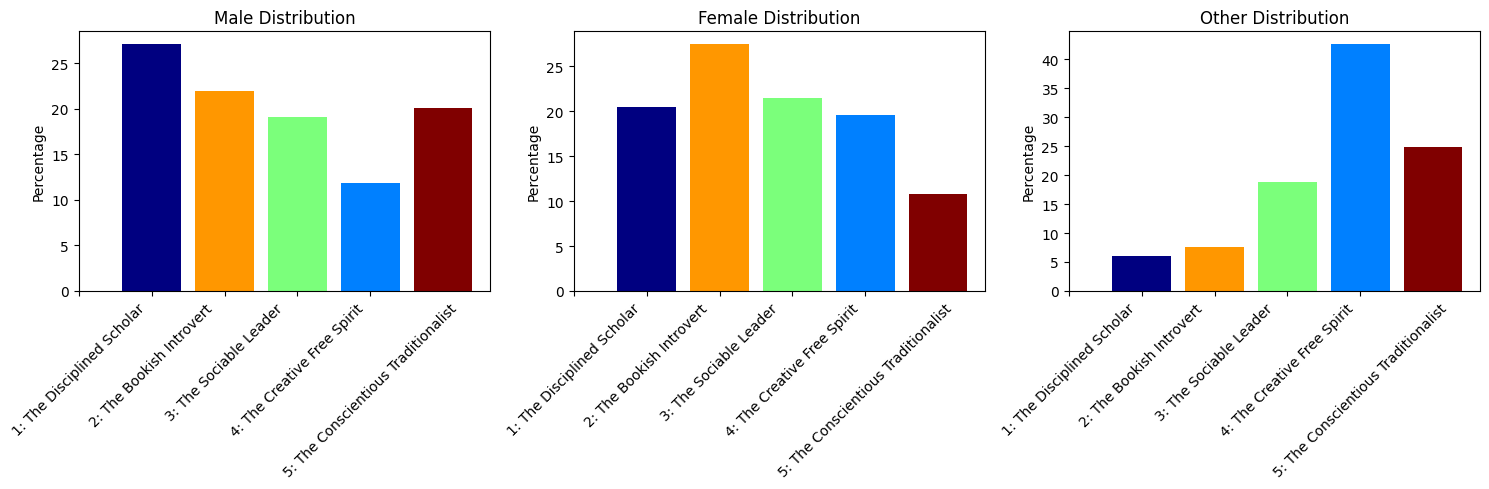

In [43]:
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

colors = ['#000080', '#0080ff', '#7bff7b', '#ff9700', '#800000']  # Specify the colors for each cluster

colorss = [[colors[0], colors[3], colors[4], colors[2], colors[1]],
           [colors[3], colors[2], colors[0], colors[1], colors[4]],
           [colors[1], colors[4], colors[2], colors[3], colors[0]]  ]    
# Iterate over each gender
for i in range(3):
    # Filter the dataframe for the current gender
    gender_data = df[df['gender'] == i+1]
    
    # Calculate the percentage of each cluster in the gender
    cluster_counts = gender_data['labels'].value_counts(normalize=True) * 100

    # Plot the histogram for label distribution in the gender
    axes2[i].bar(cluster_counts.index, cluster_counts.values, color=colorss[i])
    axes2[i].set_title(f'{description_gender[i+1]} Distribution')
    axes2[i].set_ylabel('Percentage')
    axes2[i].set_xticks(range(-1, 4))
    axes2[i].set_xticklabels(description, rotation=45)

fig2.tight_layout()
plt.show()

In [44]:
print(df['elapsed'][df['elapsed'] < 360].count()) # 7200 seconds = 2 hours
print(df['elapsed'][df['elapsed'] > 2400].count()) # 7200 seconds = 2 hours

443
1589


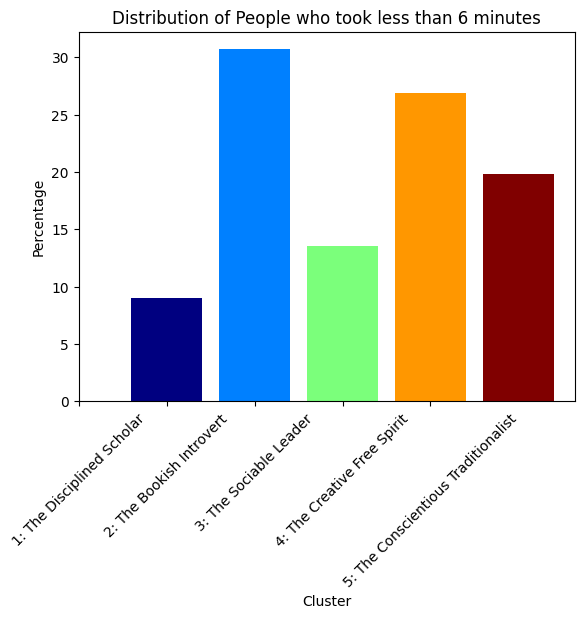

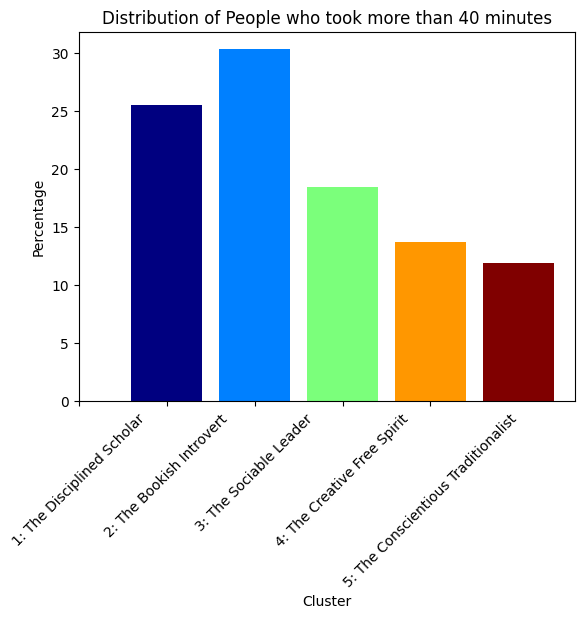

In [45]:
# Group the filtered dataframe by the 'labels' column and count the occurrences
hist_data = df[df['elapsed'] < 360].groupby('labels').size()

# Calculate the total count
total_count = hist_data.sum()

# Normalize the data by dividing the count by the total count and multiply by 100
hist_data_normalized = hist_data / total_count * 100

# Plot the histogram with x-axis labels from the 'description' list
plt.bar(description, hist_data_normalized.values, color = colors)
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Distribution of People who took less than 6 minutes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xticks(range(-1, 4), description)
plt.show()

# Group the filtered dataframe by the 'labels' column and count the occurrences
hist_data = df[df['elapsed'] > 2400].groupby('labels').size()

# Calculate the total count
total_count = hist_data.sum()

# Normalize the data by dividing the count by the total count and multiply by 100
hist_data_normalized = hist_data / total_count * 100

# Plot the histogram with x-axis labels from the 'description' list
plt.bar(description, hist_data_normalized.values, color = colors)
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Distribution of People who took more than 40 minutes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xticks(range(-1, 4), description)
plt.show()
